In [1]:
import importlib
import numpy as np
import numpy.linalg as LA
import matplotlib.pyplot as plt
import pandas as pd

import sys
sys.path.append("../..")
from mantis.algorithms import HySiME, RMUSIC, DANSER
from mantis.algorithms import utils 

In [650]:
types = [
    'Vegetation',
    'SoilsAndMixtures',
    'Liquids',
#     'Minerals',
    'ArtificialMaterials',
    'OrganicCompounds',
#     'Coatings'
    ]

lib = utils.LoadSpecLib()
lib_df = utils.MakeDataframe(lib, types=types).dropna(axis='columns',how="any")

lib_df = lib_df.apply(lambda col: col / col.max())

lib_df.head()

,Marsh SPPA67%...a CRMS326v10,Grass_dry.7+.3green AMX30,Willow_Dead FluvTailSite_A,Aspen_Leaf-B DW92-3,S.alterniflora CRMS322 NPV,Stonwll_Ply+.1grnGrass AMX33,S.altern. DWV6a4-0511 gray.a,Willow Willow-Leaves-1 dry,Antigorite+.33DryGrass AMX25,Lawn_Grass GDS91 green,...,Acetylene MTG 80K,trans-beta-Methylstyrene 85K,5-Hydroxymethyluracil 85K,Pyrazine SA-W401501,2-4-Diaminopyrimidine 468231,Triphenylene SA-T82600,Phenol SA-P5566,5-Aminoorotic SA-191213 85K,Glucose SA-G8270,cis-Stilbene SA-S4808 75K
365.92999,0.069095,0.047545,0.011529,0.076014,0.109262,0.213752,0.179837,0.094278,0.542412,0.034286,...,0.850856,0.556527,0.830470,0.480720,0.062245,0.108952,0.986636,0.085140,0.992200,0.532048
375.59399,0.066836,0.050028,0.032370,0.074285,0.111112,0.226670,0.180732,0.083395,0.560677,0.030697,...,0.872096,0.549247,0.849142,0.496546,0.051808,0.142783,0.987544,0.075064,0.995649,0.589294
385.26201,0.066162,0.056599,0.045698,0.073370,0.117271,0.245329,0.185223,0.079396,0.578390,0.030209,...,0.878543,0.562983,0.868400,0.671439,0.051236,0.215282,0.988225,0.078133,0.997806,0.672074
394.93501,0.066141,0.069950,0.057929,0.072034,0.123980,0.264880,0.188678,0.076835,0.604691,0.033378,...,0.881136,0.587564,0.882555,0.913491,0.054005,0.282881,0.989135,0.096060,0.998876,0.750694
404.61299,0.068786,0.090643,0.071264,0.071418,0.132028,0.283117,0.191615,0.074243,0.625594,0.037176,...,0.882331,0.594080,0.896426,0.961762,0.076549,0.336960,0.989765,0.209346,0.999433,0.796636


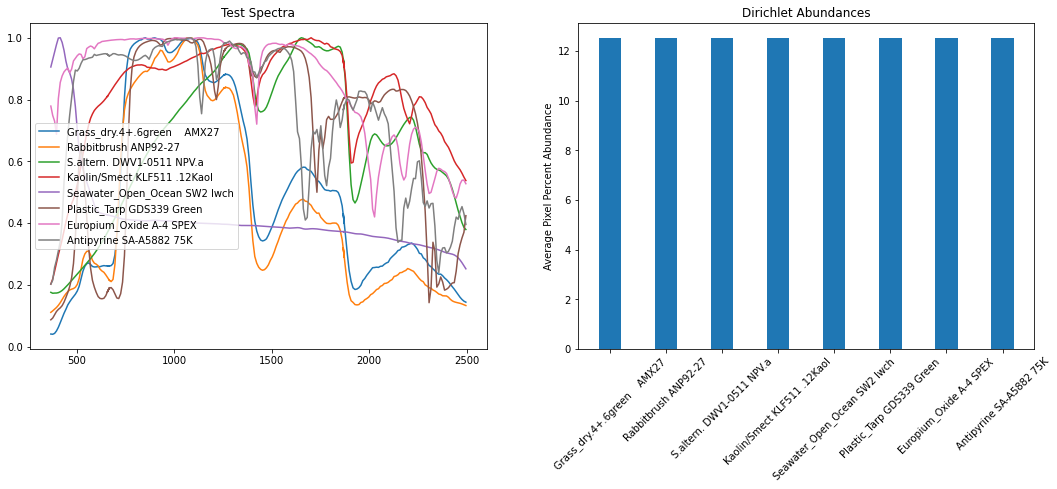

In [652]:
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(18,6))

# idx = [0,201,300,501,600,800,1000,1200]
idx = [20,30,50,120,200,250,320,475]

spectra = []
for i in idx:
    name = lib_df.columns[i]
    spectrum = lib_df[name]
    spectra.append(spectrum)
    ax[0].plot(spectrum,label=name)
    
spectra = np.array(spectra)
# abundances = np.array([1,8,1,2,1,4,2,2])
abundances = np.array([1,1,1,1,1,1,1,1])
    
    
_=ax[0].legend()
_=ax[0].set_title("Test Spectra")

ax[1].bar(range(len(abundances)), (abundances / np.sum(abundances))*100, width=0.4)
_=ax[1].set_xticks(range(len(abundances)))
_=ax[1].set_xticklabels([lib_df.columns[i] for i in idx],rotation=45)
_=ax[1].set_ylabel("Average Pixel Percent Abundance")
_=ax[1].set_title("Dirichlet Abundances")

In [657]:
def make_noise(sigma,mu,dims=(100,100),bands=224):
    """Bandwise Gaussian Noise"""
    
    #sigma_i for band i noise
    diag = []
    
    #distances from center band
    center_dists = np.array([(j - (bands/2))**2 for j in range(1,bands+1)])
    
    #2mu^2
    m = 2*(mu**2)
    
    for i in range(bands):
        
        num = np.exp(-center_dists[i] / m)
        den = np.sum(np.exp(-center_dists / m))
        
        sigma_i = sigma * (num/den)
                            
        diag.append(sigma_i)
    
    #generate noisy images from gaussian sigma_i's
    noise = [np.abs(np.random.normal(0,s,size=(100,100))) for s in diag]
                            
    return np.array(noise), np.array(diag)
    
    
sigma = 10
mu = 36
                            
noise, diag = make_noise(sigma,mu)

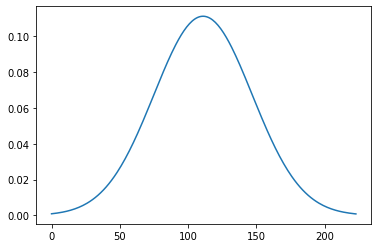

In [658]:
plt.plot(diag)

In [659]:
noise.shape

(224, 100, 100)

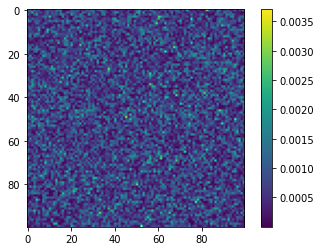

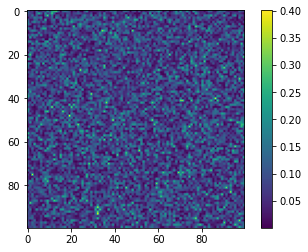

In [660]:
plt.figure()
plt.imshow(noise[0,:,:,])
plt.colorbar()
plt.figure()
plt.imshow(noise[122,:,:,])
plt.colorbar()

Synthetic HSI dimensions: (224, 100, 100)


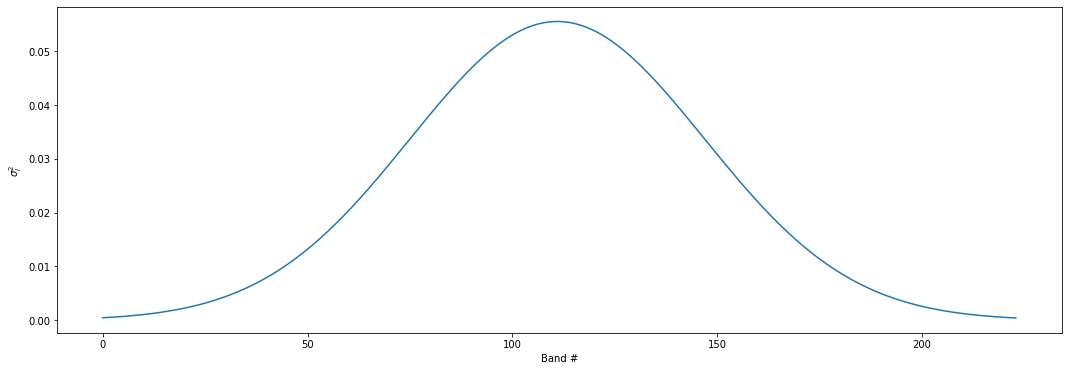

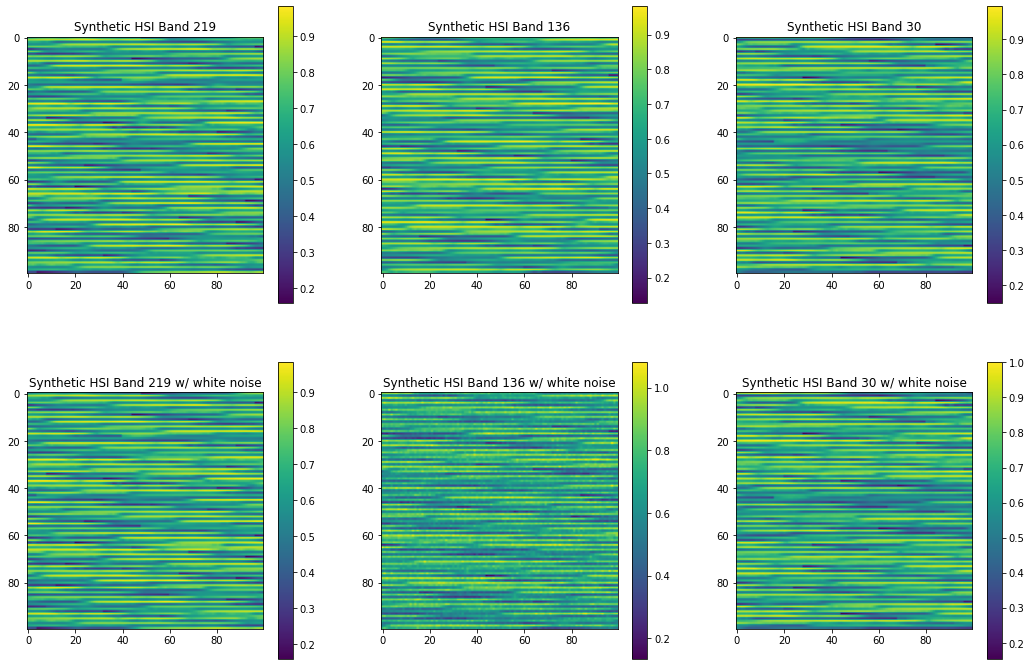

In [699]:
HSI, s = utils.synthetic_data(spectra,
                           abundances,
                           dims=(100,100),
                           pure_pix=False)

sigma, mu = 5, 36
noise, diag = make_noise(sigma,mu)

plt.figure(figsize=(18,6))
plt.plot(diag)
plt.xlabel("Band #")
plt.ylabel("$\sigma^{2}_{i}$")

print("Synthetic HSI dimensions:",HSI.shape)

fig, ax = plt.subplots(nrows=2,ncols=3,figsize=(18,12))

for i in range(3):
    
    b = np.random.choice(range(HSI.shape[0]))
    im=ax[0,i].imshow(HSI[b,:,:])
    _=ax[0,i].set_title(f"Synthetic HSI Band {b}")
    fig.colorbar(im,ax=ax[0,i])

    im=ax[1,i].imshow((HSI+noise)[b,:,:])
    _=ax[1,i].set_title(f"Synthetic HSI Band {b} w/ white noise")
    fig.colorbar(im,ax=ax[1,i])

HSI += noise

In [700]:
Y = HSI.reshape(HSI.shape[0],-1)
D = lib_df.to_numpy()

print(Y.shape)

(224, 10000)


Number of Detected Spectra: 69
True Number of Spectra: 8


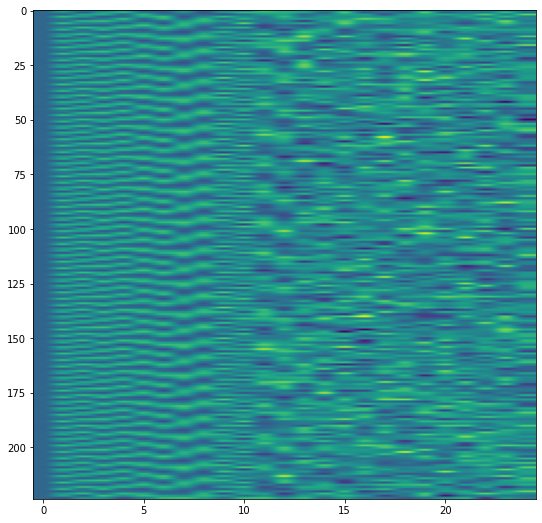

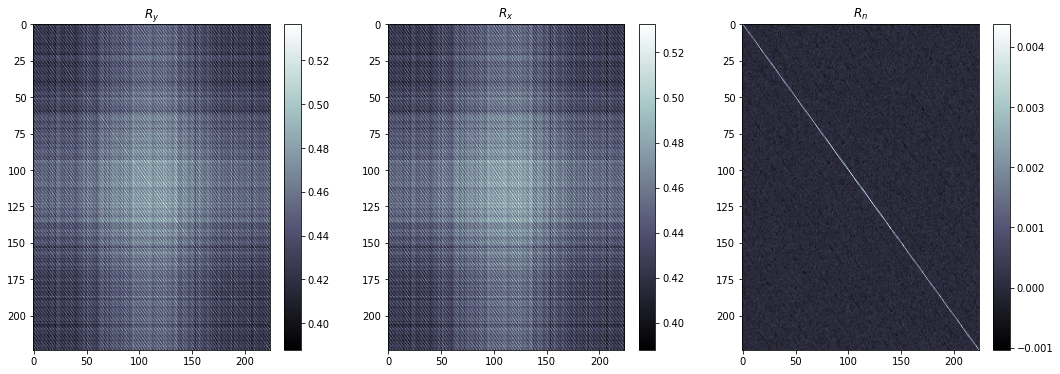

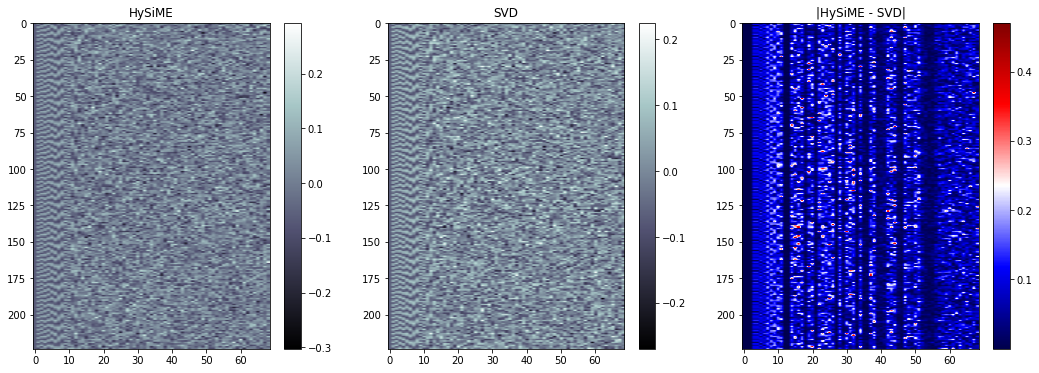

In [701]:
importlib.reload(HySiME)
Us, E, Rn, Rx, Ry = HySiME.HySiME(Y, developing=True)

k = Us.shape[1]

plt.figure(figsize=(9,9))
plt.imshow(E[:,:25], aspect='auto')

print(f"Number of Detected Spectra: {k}")
print(f"True Number of Spectra: {len(abundances)}")

U,E,V = np.linalg.svd(Y)
Us_svd = U[:,:k]

fig, ax = plt.subplots(nrows=1,ncols=3,figsize=(18,6))
ry_img = ax[0].imshow(Ry ,aspect='auto',cmap='bone')
ax[0].set_title("$R_{y}$")
rx_img = ax[1].imshow(Rx ,aspect='auto',cmap='bone')
ax[1].set_title("$R_{x}$")
rn_img = ax[2].imshow(Rn,aspect='auto',cmap='bone')
ax[2].set_title("$R_{n}$")

plt.colorbar(ry_img,ax=ax[0])
plt.colorbar(rx_img,ax=ax[1])
plt.colorbar(rn_img,ax=ax[2])


fig, ax = plt.subplots(nrows=1,ncols=3,figsize=(18,6))
us_img = ax[0].imshow(Us ,aspect='auto',cmap='bone')
ax[0].set_title("HySiME")
svd_img = ax[1].imshow(Us_svd ,aspect='auto',cmap='bone')
ax[1].set_title("SVD")
diff_img = ax[2].imshow(np.abs(Us - Us_svd)[:,:k],aspect='auto',cmap='seismic')
ax[2].set_title("|HySiME - SVD|")

plt.colorbar(us_img,ax=ax[0])
plt.colorbar(svd_img,ax=ax[1])
plt.colorbar(diff_img,ax=ax[2])

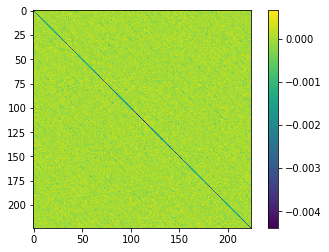

In [713]:
plt.imshow(Rx - Ry)
plt.colorbar()

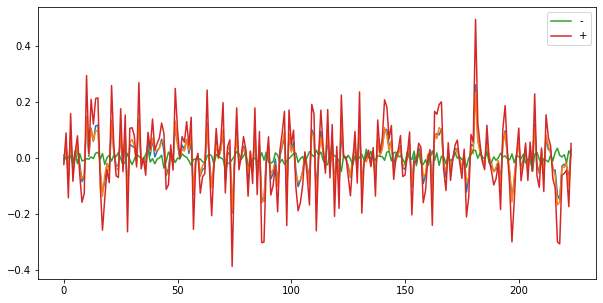

In [646]:
i=35

plt.figure(figsize=(10,5))
plt.plot(Us[:,i])
plt.plot(Us_svd[:,i])
plt.plot(Us[:,i] - Us_svd[:,i],label="-")
plt.plot(Us[:,i] + Us_svd[:,i],label="+")
plt.legend()

In [647]:
importlib.reload(RMUSIC)
rmusic = RMUSIC.RMUSIC(Y,D,Us[:,:6], alpha=0.88)
rmusic_svd = RMUSIC.RMUSIC(Y,D,Us_svd[:,:6], alpha=0.88)

spec_idx = np.argsort(rmusic)[:k]
spec_idx_svd = np.argsort(rmusic_svd)[:k]

HYSiME:
*------------------------------*
| Average Metric Score: 0.1052 |
*------------------------------*


SVD:
*------------------------------*
| Average Metric Score: 0.1052 |
*------------------------------*


,rmusic,rmusic_svd
Beryl HS180.1B,1.038234e-11,2.060856e-10
Spodumene HS210.3B,1.778856e-11,5.077290e-11
Albite HS324.3B Plagioclase,4.214968e-10,3.465546e-10
Nickel_Powder SA-577995 nano,4.600470e-10,3.210634e-10
Hornblende HS177.6,5.591935e-10,6.088054e-10
...,...,...
Bytownite HS105.2B Plagio,2.403363e-07,2.352160e-07
Topaz Tarryalls_#4,2.411745e-07,2.381664e-07
Corundum HS283.1B,2.454707e-07,2.487833e-07
Wollastonite HS348.3B,2.497869e-07,2.487161e-07


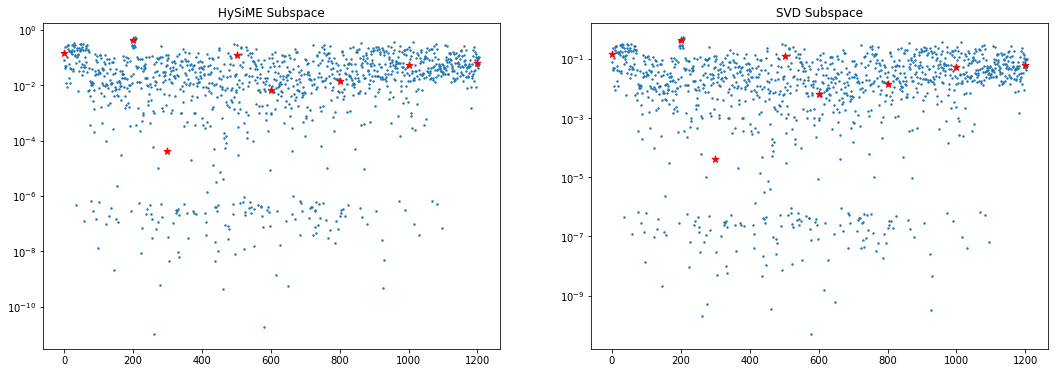

In [648]:
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(18,6))#,sharey=True)

ax[0].scatter(range(len(rmusic)),rmusic,s=2)
ax[0].scatter(idx,[rmusic[i] for i in idx],
            s=50,marker="*",c='r')
ax[0].set_title("HySiME Subspace")
ax[0].set_yscale('log')

ax[1].scatter(range(len(rmusic_svd)),rmusic_svd,s=2)
ax[1].scatter(idx,[rmusic_svd[i] for i in idx],
            s=50,marker="*",c='r')
ax[1].set_title("SVD Subspace")
ax[1].set_yscale('log')

print("HYSiME:")
derived_spectra = {}
for i in spec_idx:
    derived_spectra[lib_df.columns[i]] = [rmusic[i],rmusic_svd[i]]
    
    if i in idx:
        print(" - HySiME Correctly detected:",lib_df.columns[i])
        
print("*------------------------------*")
print("| Average Metric Score:",round(np.sum([rmusic[i] for i in idx])/len(idx),4),"|")
print("*------------------------------*")

print("\n\nSVD:")
for i in spec_idx_svd:
    if i in idx:
        print("SVD Correctly detected:",lib_df.columns[i])
        
print("*------------------------------*")
print("| Average Metric Score:",round(np.sum([rmusic_svd[i] for i in idx])/len(idx),4),"|")
print("*------------------------------*")

new_dict = pd.DataFrame.from_dict(derived_spectra,orient='index',columns=["rmusic","rmusic_svd"])

D_tilda = lib_df[new_dict.index].to_numpy()
new_dict

Text(0.5, 1.0, 'SVD Spectra')

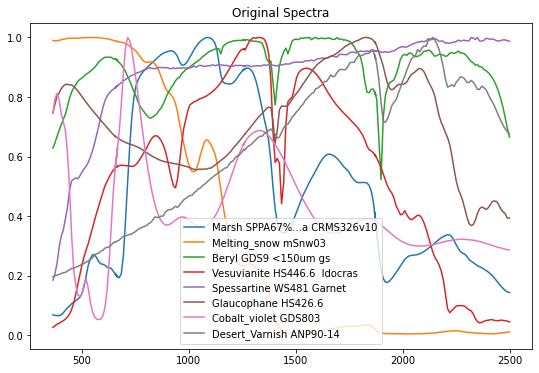

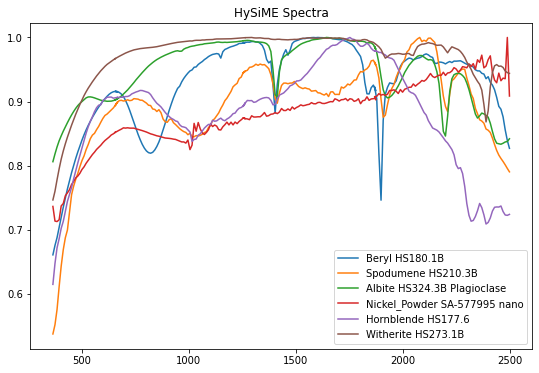

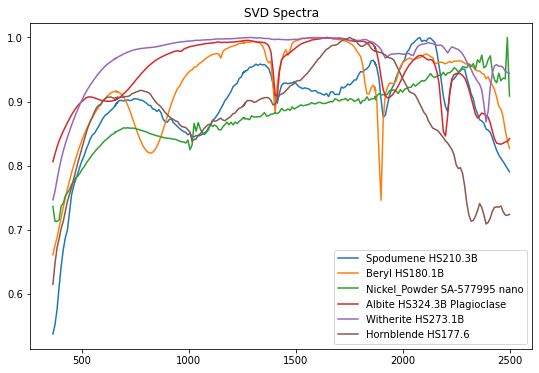

In [649]:
plt.figure(figsize=(9,6))
for i in idx:
    name = lib_df.columns[i]
    plt.plot(lib_df[name],label=name)
plt.legend()
plt.title("Original Spectra")
    
plt.figure(figsize=(9,6))
for i in spec_idx[:6]:
    name = lib_df.columns[i]
    plt.plot(lib_df[name],label=name)
plt.legend()
plt.title("HySiME Spectra")

plt.figure(figsize=(9,6))
for i in spec_idx_svd[:6]:
    name = lib_df.columns[i]
    plt.plot(lib_df[name],label=name)
plt.legend()
plt.title("SVD Spectra")

In [502]:
importlib.reload(DANSER)
C, D_tilda_adj = DANSER.DANSER(Y,D_tilda, mu=10e6, max_iter=2000)

Max Iters Reached


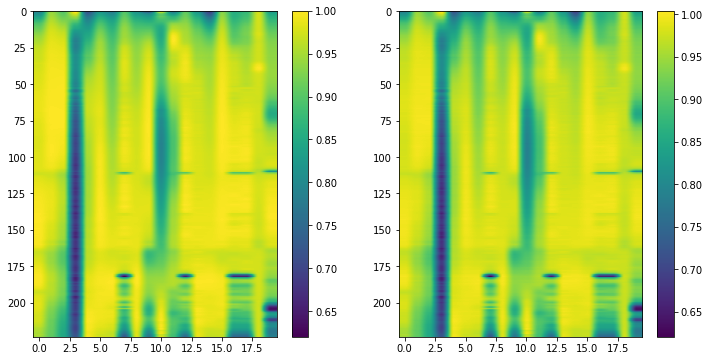

In [503]:
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(12,6))

dtild = ax[0].imshow(D_tilda,aspect="auto")
plt.colorbar(dtild,ax=ax[0])

dtildadj = ax[1].imshow(D_tilda_adj,aspect="auto")
plt.colorbar(dtildadj,ax=ax[1])

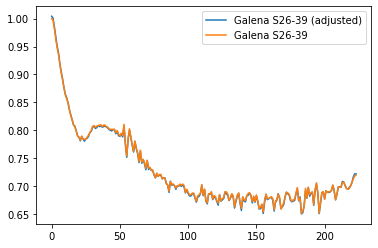

In [506]:
i = 3
true = D_tilda[:,i]
adj = D_tilda_adj[:,i]
name = lib_df.columns[spec_idx[i]]
plt.plot(adj,label=f"{name} (adjusted)")
plt.plot(true, label=f"{lib_df.columns[spec_idx[i]]}")
plt.legend()

Dirichlet Abundance: 0.125
Average DANSER pixel Abundance: 0.052


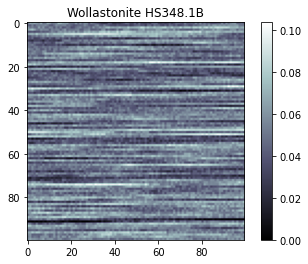

In [513]:
i=6
plt.imshow(C[i,:].reshape((100,100)),
          cmap='bone')
plt.title(new_dict.index[i])
plt.colorbar()

print("Dirichlet Abundance:",abundances[i]/len(abundances))
print("Average DANSER pixel Abundance:",round(np.mean(C[i,:]),3))